In [1]:
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import tensorflow as tf

import scipy
from scipy.io import loadmat
import re

import string
import imageio
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import random
import time
from tqdm import trange

import warnings
warnings.filterwarnings('ignore')

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower',
                                                     word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('2428',
                                                     id2word_dict['2428']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'],
                                         word2Id_dict['<RARE>']))


there are 6375 vocabularies in total
Word to id mapping, for example: flower -> 2428
Id to word mapping, for example: 2428 -> flower
Tokens: <PAD>: 6372; <RARE>: 6374


In [3]:
print (word2Id_dict['<ST>'])
print (word2Id_dict['<ED>'])

798
1784


In [4]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [5]:
df_img = df['ImagePath'].values
print('There are %d image in training data' % (len(df_img)))

There are 7370 image in training data


In [6]:
df_caption = df['Captions'].values

In [7]:
print (df_caption[2])

[['2435', '2428', '2505', '2431', '2444', '2427', '2433', '2434', '2530', '2444', '2449', '6372', '6372', '6372', '6372', '6372', '6372', '6372', '6372', '6372'], ['2430', '2428', '2431', '2427', '2436', '2432', '2444', '2429', '2510', '2448', '6372', '6372', '6372', '6372', '6372', '6372', '6372', '6372', '6372', '6372'], ['2430', '2428', '2431', '2451', '2429', '3361', '2468', '2427', '2433', '2483', '2461', '2439', '2696', '2503', '2445', '2444', '2429', '2611', '6372', '6372'], ['2430', '2442', '2434', '2452', '2428', '2433', '2451', '2444', '2427', '2453', '2467', '6372', '6372', '6372', '6372', '6372', '6372', '6372', '6372', '6372'], ['2435', '2428', '2431', '2427', '2436', '2432', '2487', '2444', '2433', '2434', '2449', '2522', '2448', '2427', '6372', '6372', '6372', '6372', '6372', '6372'], ['2430', '2428', '2431', '2444', '2429', '2440', '2427', '2436', '2527', '2434', '2510', '2448', '6372', '6372', '6372', '6372', '6372', '6372', '6372', '6372'], ['2430', '2428', '2431', '2

In [8]:
d_captions = []
for i in trange(len(df_caption)):
    caps = []
    for caption in df_caption[i]:
        cap = []
        cap.append(word2Id_dict['<ST>'])
        for word in caption:
            cap.append(word)
        cap.append(word2Id_dict['<ED>'])
        caps.append(cap)
    d_captions.append(caps)


100%|██████████| 7370/7370 [00:00<00:00, 22762.28it/s]


In [9]:
d_captions = np.asarray(d_captions)
print (type(df_img))
print (d_captions.shape)

<class 'numpy.ndarray'>
(7370,)


In [10]:
df_ = pd.DataFrame({
    'Captions': d_captions,
    'ImagePath': df_img                
})

df_.head(10)

,Captions,ImagePath
0,"[[798, 2430, 2428, 2431, 2427, 2436, 2432, 245...",/102flowers/image_08110.jpg
1,"[[798, 2430, 2428, 2431, 2427, 2436, 2432, 244...",/102flowers/image_07749.jpg
2,"[[798, 2435, 2428, 2505, 2431, 2444, 2427, 243...",/102flowers/image_04381.jpg
3,"[[798, 2430, 2428, 2431, 2563, 2437, 2427, 243...",/102flowers/image_04518.jpg
4,"[[798, 2435, 2428, 2427, 2432, 5409, 2429, 243...",/102flowers/image_07620.jpg
5,"[[798, 2430, 2428, 2442, 2450, 2439, 2441, 243...",/102flowers/image_00724.jpg
6,"[[798, 2428, 2433, 2438, 2427, 2429, 2487, 244...",/102flowers/image_00550.jpg
7,"[[798, 2430, 2428, 2442, 2438, 2439, 2441, 243...",/102flowers/image_07209.jpg
8,"[[798, 2428, 2431, 2427, 2436, 2432, 2440, 243...",/102flowers/image_02334.jpg
9,"[[798, 2518, 2428, 2470, 2451, 2510, 2448, 242...",/102flowers/image_07389.jpg


In [11]:
df.head(10)

,Captions,ImagePath
1855,"[[2430, 2428, 2431, 2427, 2436, 2432, 2450, 24...",/102flowers/image_08110.jpg
6790,"[[2430, 2428, 2431, 2427, 2436, 2432, 2440, 24...",/102flowers/image_07749.jpg
7908,"[[2435, 2428, 2505, 2431, 2444, 2427, 2433, 24...",/102flowers/image_04381.jpg
1805,"[[2430, 2428, 2431, 2563, 2437, 2427, 2433, 24...",/102flowers/image_04518.jpg
5679,"[[2435, 2428, 2427, 2432, 5409, 2429, 2432, 24...",/102flowers/image_07620.jpg
432,"[[2430, 2428, 2442, 2450, 2439, 2441, 2433, 24...",/102flowers/image_00724.jpg
4679,"[[2428, 2433, 2438, 2427, 2429, 2487, 2440, 36...",/102flowers/image_00550.jpg
4880,"[[2430, 2428, 2442, 2438, 2439, 2441, 2433, 24...",/102flowers/image_07209.jpg
2164,"[[2428, 2431, 2427, 2436, 2432, 2440, 2433, 24...",/102flowers/image_02334.jpg
5771,"[[2518, 2428, 2470, 2451, 2510, 2448, 2427, 24...",/102flowers/image_07389.jpg


In [12]:
df_.to_csv(data_path + '/text_ImgPath.csv', index=False)

# Pretrain RNN

In [13]:
def data_iterator_rnn(filenames, batch_size):
    captions = df_['Captions'].values
    caption = []
    
    for _ in range(3):
        for i in range(len(captions)):
            caption.append(random.choice(captions[i]))
    caption = np.asarray(caption)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption))
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    
    iterator = dataset.make_initializable_iterator()
    output_types = dataset.output_types
    output_shapes = dataset.output_shapes
    
    return iterator, output_types, output_shapes

In [14]:
class Rnn(object):
    def __init__(self, hparas, training_phase=True, reuse=False, return_embed=False):
        self.hparas = hparas
        self.training_phase = training_phase
        self.return_embed = return_embed
        self.reuse = reuse
        self.sess = tf.Session()
        
        self._build_model()
        
    def _build_model(self):
        
        with tf.variable_scope('rnnftxt', reuse=self.reuse):
            # if self.training_phase:
            self.word_embed_matrix = tf.get_variable(
                'rnn/wordembed',
                shape=(self.hparas['VOCAB_SIZE'], self.hparas['EMBED_DIM']),
                initializer=tf.random_normal_initializer(stddev=0.02),
                dtype=tf.float32)
            #else:
            #    self.word_embed_matrix = tf.Variable(self.embed_matrix)
                
            self.text = tf.placeholder(dtype=tf.int64, shape=[hparas['BATCH_SIZE'], None], name='caption')
            embedded_word_ids = tf.nn.embedding_lookup(self.word_embed_matrix, self.text)
            embedded_word_ref = tf.nn.embedding_lookup(self.word_embed_matrix, self.text)
            
            # seq = tf.one_hot(self.seq, 22)
        with tf.variable_scope('rnncell', reuse=self.reuse):
            LSTMCell = tf.contrib.rnn.BasicLSTMCell(
                self.hparas['TEXT_DIM'],
                reuse=self.reuse)
            initial_state = LSTMCell.zero_state(
                self.hparas['BATCH_SIZE'],
                dtype=tf.float32)
            rnn_net = tf.nn.dynamic_rnn(
                cell=LSTMCell,
                inputs=embedded_word_ids,
                initial_state=initial_state,
                dtype=tf.float32,
                time_major=False,
                scope='rnn/dynamic')
            self.rnn_net = rnn_net
            self.outputs_last = rnn_net[0][:, -1, :]
            self.outputs = rnn_net[0]
        
        
        
        if self.training_phase:
            with tf.variable_scope('rnn/logits'):
                self.logits = tf.contrib.layers.fully_connected(
                    self.outputs, 
                    self.hparas['TEXT_DIM'], 
                    None)
                
            with tf.variable_scope('rnn/loss'):
                self.loss = tf.reduce_sum(
                    tf.nn.softmax_cross_entropy_with_logits(
                    logits=self.logits[:, :-1], 
                    labels=embedded_word_ref[:, 1:]))
            
            with tf.variable_scope('rnn/optim'):
                self.optim = tf.train.AdamOptimizer(self.hparas['LR'], beta1=self.hparas['BETA']) \
                                        .minimize(self.loss)
            
        
        self.sess = tf.Session()
        self.saver = tf.train.Saver()
        self.global_step = tf.train.get_or_create_global_step()
        self.sess.run(tf.global_variables_initializer()) 
            
        
    def train(self, iterator_train):
        
        self.sess.run(iterator_train.initializer)
        
        self.losses = []
        for _epoch in trange(self.hparas['N_EPOCH']):
            start_time = time.time()
            
            epoch_loss = 0
            for _step in range(100):
                next_element = iterator_train.get_next()
                text = self.sess.run(next_element)
                
                loss, _ = self.sess.run([self.loss, self.optim],
                                        feed_dict={
                                            self.text: text
                                        })
                epoch_loss += loss
            self.losses.append(epoch_loss)
            
        self.save(self.global_step)
        
    def inference(self, text):
        output_embedded = self.sess.run(self.outputs_last, feed_dict={self.text: text})
        return output_embedded
        
    
    def save(self, global_step):
        gs = global_step.eval(self.sess)
        self.saver.save(self.sess, 'model/' + 'preTrainRnn.ckpt', global_step=gs)

    def restore(self):
        ckpt = tf.train.get_checkpoint_state('./model')
        if ckpt and ckpt.model_checkpoint_path:
            print (ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, ckpt.model_checkpoint_path)
        return self.sess

In [15]:
def get_hparas():
    hparas = {
        'MAX_SEQ_LENGTH': 22,
        'EMBED_DIM': 64,  # word embedding dimension
        'VOCAB_SIZE': len(vocab),
        'TEXT_DIM': 64,  # text embrdding dimension
        'RNN_HIDDEN_SIZE': 64,
        'Z_DIM': 64,  # random noise z dimension
        'IMAGE_SIZE': [64, 64, 3],  # render image size
        'BATCH_SIZE': 64,
        'LR': 0.00002,
        'DECAY_EVERY': 100,
        'LR_DECAY': 0.5,
        'BETA': 0.5,  # AdamOptimizer parameter
        'N_EPOCH': 100,
        'N_SAMPLE': num_training_sample
    }
    return hparas

In [16]:
tf.reset_default_graph()
BATCH_SIZE = 64
iterator_train, types, shapes = data_iterator_rnn(
    data_path + '/text2ImgData.pkl', BATCH_SIZE)
# iter_initializer = iterator_train.initializer

hparas = get_hparas()
caption = tf.placeholder(dtype=tf.int64, shape=[hparas['BATCH_SIZE'], None], name='caption')
text_encoder = Rnn(hparas=hparas, training_phase=True, reuse=False)

text_encoder.train(iterator_train)

100%|██████████| 100/100 [47:55<00:00, 37.57s/it]


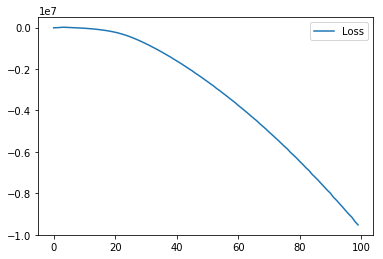

In [17]:
import matplotlib.pyplot as plt

plt_loss = plt.plot([text_encoder.losses[i] for i in range(len(text_encoder.losses))])
plt.legend(['Loss'])
plt.show()

In [ ]:
hparas = get_hparas()

tf.reset_default_graph()
t2 = Rnn(hparas=hparas, training_phase=False, reuse=False)
t2.restore()

# assert(t2.word_embed_matrix == text_encoder.word_embed_matrix)

In [ ]:
BATCH_SIZE = 64
iterator_train, types, shapes = data_iterator_rnn(
    data_path + '/text2ImgData.pkl', BATCH_SIZE)

iter_initializer = iterator_train.initializer
next_element = iterator_train.get_next()
t2.sess.run(iter_initializer)
text = t2.sess.run(next_element)
output = t2.sess.run(t2.outputs_last, feed_dict={t2.text: text})
    
print (output)

In [ ]:
print (text)

In [ ]:
ot = t2.inference(text)

In [ ]:
for i in range(ot.shape[0]):
    for k in range(ot.shape[1]):
        assert (ot[i][k] == output[i][k])

In [ ]:
print (range(i))

In [ ]:
eb = tf.Variable(wd)

In [ ]:
print (type(eb))

In [ ]:
assert (t2.word_embed_matrix == eb)

In [ ]:
print (eb.shape)
print (t2.word_embed_matrix.shape)

In [19]:
# t2.sess.close()
text_encoder.sess.close()